# Assignment 2
## Question 6
Diffusion-Limited Aggregation (DLA)
With assistance by Rae Tiffen

In [37]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from matplotlib import animation
from IPython.display import HTML

In [38]:
def dla(h: int,w: int,steps: int,coverage: float):
    """ 
        Inputs:
        h: height of world
        w: width of world
        steps: number of steps to run
        coverage: in [0,1], percent of cells to be occupied in the initial world
    """

    # Setup
    world = (np.random.rand(h,w) < coverage).astype(int)
    world[h // 2, w // 2] = 2 # Initial center

    # Run walks
    for i in range(int(steps)):
        world = step(world)
    
    # Plot
    plot(world, h, w, steps)
    return world

def step(world):
    h, w = world.shape
    next_world = world.copy()

    # Iterate through cells in a different order every time
    cells = [(r,c) for r in range(h) for c in range(w)]
    random.shuffle(cells)

    for row, col in cells:
        if world[row,col] == 1: # If it will do something
            # If any neighbor is a 2, become a 2
            if (world[(row-1) % h, col] == 2 or world[(row+1) % h, col] == 2 or world[row, (col-1) % w] == 2 or world[row, (col+1) % w] == 2):
                next_world[row,col] = 2
            # Else, move
            else:
                dir = roll()
                if dir == "up":
                    if world[(row-1) % h, col] == 0 and next_world[(row-1) % h, col] == 0: # If unoccupied
                        next_world[row, col] = 0
                        next_world[(row-1) % h, col] = 1
                elif dir == "down":
                    if world[(row+1) % h, col] == 0 and next_world[(row+1) % h, col] == 0: # If unoccupied
                        next_world[row, col] = 0
                        next_world[(row+1) % h, col] = 1
                elif dir == "left":
                    if world[row, (col-1) % w] == 0 and next_world[row, (col-1) % w] == 0: # If unoccupied
                        next_world[row, col] = 0
                        next_world[row, (col-1) % w] = 1
                elif dir == "right":
                    if world[row, (col+1) % w] == 0 and next_world[row, (col+1) % w] == 0: # If unoccupied
                        next_world[row, col] = 0
                        next_world[row, (col+1) % w] = 1
    return next_world

def roll():
    die = random.uniform(0,1)
    if die < 0.25:
        return "up"
    if die < 0.5:
        return "down"
    if die < 0.75:
        return "left"
    else:
        return "right"
    
def plot(world, h, w, steps, withSignal: bool = False):
    cmap = ListedColormap(['white','lightgreen','darkgreen'])
    plt.imshow(world, cmap=cmap, origin='lower')
    plt.xticks(np.arange(0, w+1, 100))
    plt.yticks(np.arange(0, h+1, 100))
    if withSignal:
        plt.savefig(f"plots/{h}x{w}_{steps}_steps_world_with_signal")
        return
    
    plt.savefig(f"plots/{h}x{w}_{steps}_steps_world")
    return
    

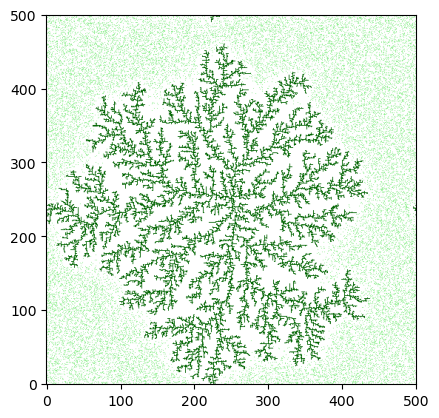

In [39]:
world_large = dla(
    h = 500, 
    w = 500, 
    steps = 5000, 
    coverage = 0.20)

# Question 7
**Implement a speed up:**

This idea was inspired by our class discussion. While it is yet another bias technique, it is a cool take. The idea is to broadcast a signal when a particle joins the cluster. The signal is implemented as a 2D numpy array called `attraction_field` that matches the dimensions of the world grid (h x w). Each cell in this array stores a floating-point value representing the strength of the attraction signal at that location.

When a moving particle (state 1) joins the structure (becomes state 2), it broadcasts a signal via the broadcast_signal function. The signal spreads in a radius around the newly joined cell, with strength that decreases with distance.

Free particles can be influenced by the signal:
`if attraction_field[row, col] > 0.1:`

if the above condition is met the idea is to bias their random walk in the direction of the cluster. This makes them more likely to move toward the structure where signals are strongest.


In [ ]:
def dla_with_signal(h, w, steps, coverage, signal_radius=5, signal_strength=0.7, frame_interval: int = 50, animate: bool = False):
    # Setup
    world = (np.random.rand(h,w) < coverage).astype(int)
    world[h // 2, w // 2] = 2
    attraction_field = np.zeros((h, w))  # Initialize the field
    frames = [world.copy()]  # Start with initial state

    # Run simulation
    for i in range(steps):
        world, attraction_field = step_with_signal(world, attraction_field, 
                                                signal_radius, signal_strength)
        if animate and (i + 1) % frame_interval == 0:  # Every N steps
            frames.append(world.copy())
    if animate == False:
        plot(world, h, w, steps, withSignal=True)

    return frames, world, attraction_field


def step_with_signal(world, attraction_field, signal_radius=5, signal_strength=0.7, decay_rate=0.9):
    h, w = world.shape
    next_world = world.copy()
    next_field = attraction_field * decay_rate  # Decay existing field
    # print(np.sum(next_field > 0.2)) # verify decay works as expected
    # Track newly joined cells
    new_joins = []
    
    # Iterate through cells
    cells = [(r,c) for r in range(h) for c in range(w)]
    random.shuffle(cells)
    
    for row, col in cells:
        if world[row,col] == 1:
            # Check if touching structure
            if (world[(row-1) % h, col] == 2 or world[(row+1) % h, col] == 2 or 
                world[row, (col-1) % w] == 2 or world[row, (col+1) % w] == 2):
                
                next_world[row,col] = 2
                new_joins.append((row, col))  # Record this join!
                
            else:
                # Check if under influence of attraction field
                if attraction_field[row, col] > 0.1:  # Threshold for effect
                    dir = biased_roll(row, col, h, w, attraction_field)
                else:
                    dir = roll()  # Normal random walk
                
                # Move based on direction
                move_particle(world, next_world, row, col, dir, h, w)
    
    # Throw signals from newly joined cells
    for row, col in new_joins:
        broadcast_signal(next_field, row, col, h, w, signal_radius, signal_strength)
    
    return next_world, next_field


def broadcast_signal(field, center_row, center_col, h, w, radius, strength):
    """
    Adds attraction field around a newly joined particle
    params:
        field: 2d array, attraction field
        center_row: int, row of the center of the field
        center_col: int, column of the center of the field
        h: int, height of the field
        w: int, width of the field
        radius: int, radius of the field
    """
    for dr in range(-radius, radius+1):
        for dc in range(-radius, radius+1):
            distance = np.sqrt(dr**2 + dc**2)
            if distance <= radius and distance > 0:
                r = (center_row + dr) % h
                c = (center_col + dc) % w
                # Strength falls off with distance
                field[r, c] = max(field[r, c], strength * (1 - distance/radius))


def biased_roll(row, col, h, w, attraction_field):
    """
    Biased random walk based on attraction field gradient.
    Particles move toward higher field values (toward the structure).
    """
    # Check field strength in each direction
    field_up = attraction_field[(row-1) % h, col]
    field_down = attraction_field[(row+1) % h, col]
    field_left = attraction_field[row, (col-1) % w]
    field_right = attraction_field[row, (col+1) % w]
    
    # Use field strengths directly as weights (with a baseline)
    # Higher field = higher probability to move that direction
    baseline = 1.0  # Ensures all directions have some probability
    bias_multiplier = 5.0  # Amplify the effect of the field
    
    weights = {
        "up": baseline + bias_multiplier * field_up,
        "down": baseline + bias_multiplier * field_down,
        "left": baseline + bias_multiplier * field_left,
        "right": baseline + bias_multiplier * field_right
    }
    
    # Normalize to get probabilities
    total = sum(weights.values())
    if total > 0:
        weights = {k: v/total for k, v in weights.items()}
    else:
        weights = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
    
    # Random choice based on weights
    r = random.random()
    cumulative = 0
    for dir, prob in weights.items():
        cumulative += prob
        if r < cumulative:
            return dir
    return "right"


def move_particle(world, next_world, row, col, dir, h, w):
    """Helper to move a particle in a direction"""
    if dir == "up":
        if world[(row-1) % h, col] == 0 and next_world[(row-1) % h, col] == 0:
            next_world[row, col] = 0
            next_world[(row-1) % h, col] = 1
    elif dir == "down":
        if world[(row+1) % h, col] == 0 and next_world[(row+1) % h, col] == 0:
            next_world[row, col] = 0
            next_world[(row+1) % h, col] = 1
    elif dir == "left":
        if world[row, (col-1) % w] == 0 and next_world[row, (col-1) % w] == 0:
            next_world[row, col] = 0
            next_world[row, (col-1) % w] = 1
    elif dir == "right":
        if world[row, (col+1) % w] == 0 and next_world[row, (col+1) % w] == 0:
            next_world[row, col] = 0
            next_world[row, (col+1) % w] = 1
     

## Question 8 
Produce a figure of the structure created by your DLA code with the speed up.

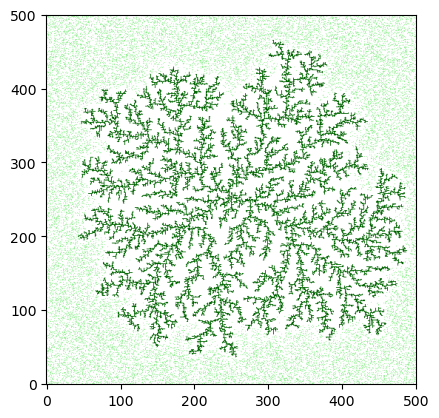

In [41]:
frames, world_with_speedup, field_with_speedup = dla_with_signal(h=500, w=500, steps=3000, coverage=0.2, signal_radius=7, signal_strength=0.7, frame_interval=50)


## Question 9
Box-Counting

In [56]:
def box_counting_method(world_to_apply_box_method, consider_every_x_boxes, image_description):
    dict_nr_boxes = {}
    #The maximum size should be one that covers the entire lattice. this occurs when it is equal to the biggest dimension of it 
    box_max_size=max(world_to_apply_box_method.shape)

    for box_size in range(1,box_max_size+1,consider_every_x_boxes):
        nr_boxes_aux = 0
        box_start_coordinates=[]
        for row in range(0,world_to_apply_box_method.shape[0],box_size):
            for col in range(0,world_to_apply_box_method.shape[1],box_size):
                
                #selected the fraction of world to analyse 
                filtered_world = world_to_apply_box_method[row:row+box_size,col:col+box_size]
                box_aux = np.full((box_size,box_size),2)

                #We need to adjsut for filtered_world shape due to borders of lattice
                box = box_aux[0:filtered_world.shape[0],0:filtered_world.shape[1]]
                max_ = np.max(filtered_world - box)
                

                #if there is at least one value equal to 0 it means that it found at least one CA element active in that box
                if max_ ==0:
                    nr_boxes_aux+=1
        
        dict_nr_boxes[box_size] = nr_boxes_aux


    xs_ = np.log(np.array(list(dict_nr_boxes.keys())))
    ys_ = np.log(np.array(list(dict_nr_boxes.values())))
    df = pd.DataFrame({'x': xs_, 'y': ys_})

    # Plot linear fit
    sns.regplot(x='x', y='y', data=df, ci=None, line_kws={'color': 'green'})
    plt.xlabel("log10(Box size)")
    plt.ylabel("log10(Number of Boxes)")


    res = linregress(df["x"], df["y"])

    plt.title(f"Linear Fit on Log-Log Data \n"
            f"Slope: {res.slope:.4f}, Intercept: {res.intercept:.4f}")
    plt.savefig(f"plots/{image_description}_box_count.png")

    plt.show()

    return 


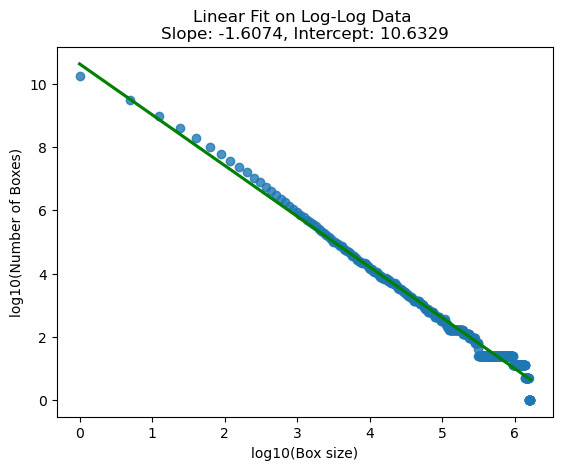

In [57]:
box_counting_method(world_to_apply_box_method = world_with_speedup, consider_every_x_boxes=1, image_description="world_with_signal")

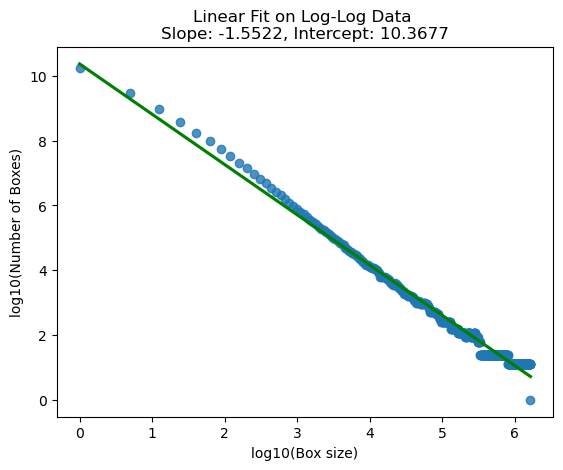

In [58]:
box_counting_method(world_to_apply_box_method = world_large, consider_every_x_boxes=1, image_description="world_large")